In [1]:
import matplotlib.pyplot as plt
import numpy as np
import datetime
from datetime import timedelta
from datetime import datetime
import yfinance as yf
import statsmodels.api as sm
import seaborn as sns
import statsmodels.tsa.stattools as ts 
import statsmodels.formula.api as smf
import pandas as pd
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.reset_option('all')
import statsmodels as sm

In [2]:
def get_data(tickers):
    tickers_str = ' '.join(tickers)
    
    df = yf.download(tickers=tickers_str,
                     start="2013-09-10", end="2023-09-10",
                     interval="1d")[["Adj Close"]]
    
    df.columns = tickers
    
    return df.dropna()

In [3]:
file_path = '/Users/sandinatatu/Desktop/FP.csv'  # On macOS
tickers = pd.read_csv(file_path)
tickers = tickers.values.tolist()
tickers = [ticker for sublist in tickers for ticker in sublist]

In [4]:
data = get_data(tickers)
data= data.dropna()
data= data / data.iloc[0]

[*********************100%%**********************]  96 of 96 completed


In [5]:
from itertools import combinations
column_names=data.columns.tolist()
column_pairs = list(combinations(column_names, 2))
print(f"There are {len(column_pairs)} possible combinations")

There are 4560 possible combinations


In [6]:
import pandas as pd
from statsmodels.tsa.stattools import adfuller

columns_to_drop = []

data_diff = data.diff().dropna()

for column in data_diff.columns:
    
    result = adfuller(data_diff[column])

    if result[1] >= 0.05:
        columns_to_drop.append(column)

In [7]:
data.drop(columns=columns_to_drop, inplace=True)

In [8]:
from statsmodels.tsa.stattools import adfuller

cointegrated=[]
pvals=[]

start_date2 = pd.Timestamp("2013-09-10")
end_date2= pd.Timestamp("2018-09-10")

for i,j in column_pairs:
    ts1=data[i][start_date2:end_date2]
    ts2=data[j][start_date2:end_date2]
    model=sm.regression.linear_model.OLS(ts1, ts2)
    model = model.fit()
    hedge = model.params[0]
    ts3=ts1-ts2*hedge
    adfresult=adfuller(ts3)
    if adfresult[1]<0.01:
        cointegrated.append([i,j])
        pvals.append(adfresult[1])
        
print(f"There are {len(cointegrated)} cointegrated pairs")

There are 35 cointegrated pairs


In [9]:
newalpha= 1- (1-0.01)**(1/35)
significant = [stock for stock, p_value in zip(cointegrated, pvals) if p_value < newalpha]

print(f"There are {len(significant)} cointegrated pairs after accounting for MCB:", significant)

There are 3 cointegrated pairs after accounting for MCB: [['AMT', 'HON'], ['DUK', 'UPS'], ['NEE', 'TMO']]


## Second Pair: DUK and UPS

In [10]:
pair = significant[1]
data2 = data[list(pair)]
ticker21 = list(pair)[0]
ticker22 = list(pair)[1]

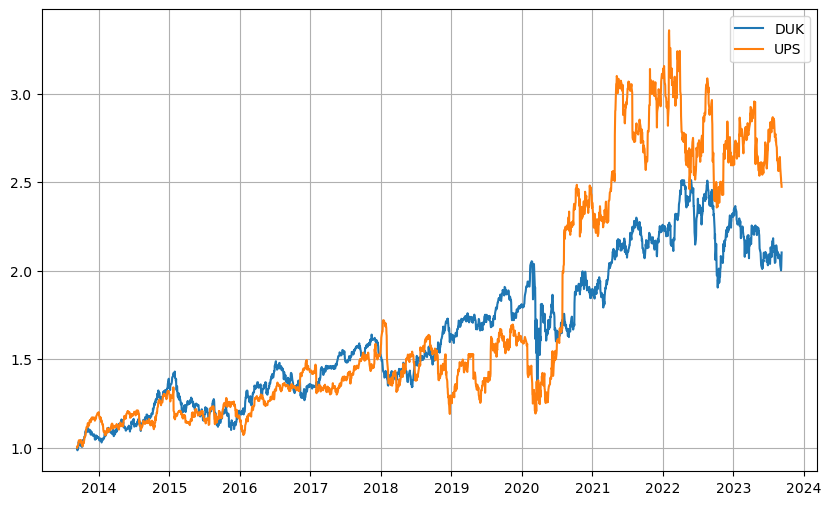

In [11]:
# Two Series
plt.figure(figsize = (10,6))
plt.plot(data2[ticker21])
plt.plot(data2[ticker22])
plt.legend([ticker21,ticker22])
plt.grid()
plt.show()

In [ ]:
Z=1.

data2["Hedge"] = 0.
data2["Spread"] = 0.
data2["Upper"] = 0.
data2["Lower"] = 0.
data2["Mean"] = 0.
data2["Signals"] = 0.

model=sm.regression.linear_model.OLS(data2[ticker21], data2[ticker22])
model = model.fit()
hedge = model.params[0]
data2["Hedge"] = hedge

data2["Spread"] = data2[ticker21] - (data2[ticker22] * hedge)

data2["Mean"] = (data2["Spread"]).rolling(400).mean()
data2["SD"] = (data2["Spread"]).rolling(400).std()


data2["Upper"] = data2["Mean"] + (Z * data2["SD"])
data2["Lower"] = data2["Mean"] - (Z * data2["SD"])

In [13]:
def strategy_signals_2(data2):
    data2["Signals"] = 0.
    for i in range(1, len(data2)):
        
        # Short Condition
        if data2["Upper"][i] < data2["Spread"][i] and data2["Spread"][i] < data2["Spread"][i-1]: 
            data2["Signals"][i] = -1.
        if (data2["Signals"][i-1] == -1.) & (data2["Spread"][i] > data2["Mean"][i]) & (all(value == -1 for value in data2["Signals"][i-100:i-1])==False):
            data2["Signals"][i] = -1.
            
        # Long Condition  
        if data2["Lower"][i] > data2["Spread"][i] and data2["Spread"][i] > data2["Spread"][i-1]:
            data2["Signals"][i] = 1.
        if (data2["Signals"][i-1] == 1.) & (data2["Spread"][i] < data2["Mean"][i]) & (all(value == 1 for value in data2["Signals"][i-100:i-1])==False):
            data2["Signals"][i] = 1.
            
    return(data2)

In [ ]:
data2 = strategy_signals_2(data2)
data2 = data2.ffill().dropna()

In [15]:
# Get Strategy Profits
data2["asset1"] = data2[ticker21].pct_change()
data2["asset2"] = data2[ticker22].pct_change()

data2["Return"] = (data2["asset1"] - (data2["Hedge"] * data2["asset2"])) * data2["Signals"].shift(1)
data2["cumulReturn"] = np.cumprod((data2["Return"]).fillna(0)+1)

In [16]:
longs = data2["Spread"][data2["Signals"] == 1.]
shorts = data2["Spread"][data2["Signals"] == -1.]

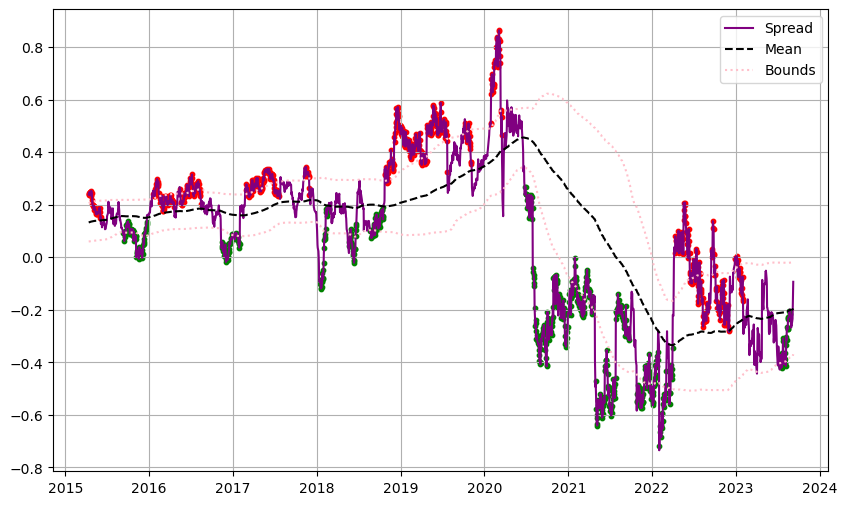

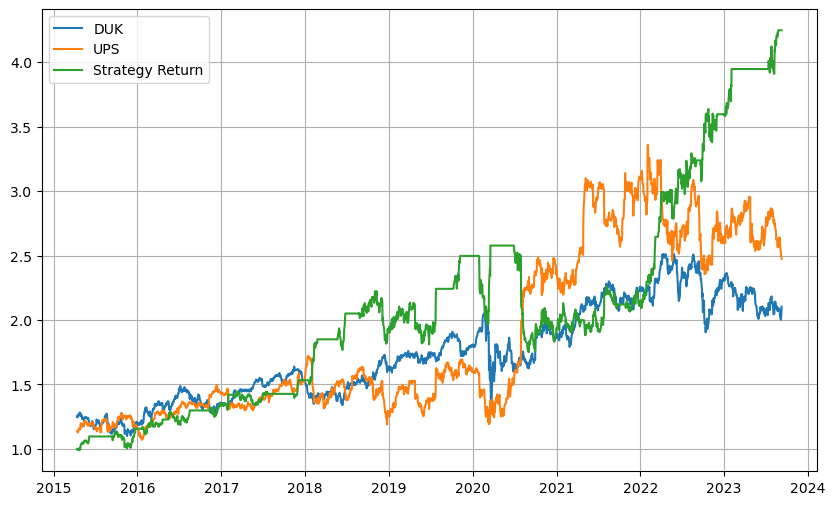

In [17]:
# Spread
pair1=data2["cumulReturn"]

plt.figure(figsize = (10,6))
plt.plot(data2["Spread"], c = "purple")
plt.plot(data2["Mean"], linestyle = "dashed", c = "black")
plt.plot(data2["Upper"], linestyle = "dotted", c = "pink")
plt.plot(data2["Lower"], linestyle = "dotted", c = "pink")

plt.scatter(longs.index, longs, c = "green" , s = 10 )
plt.scatter(shorts.index, shorts, c = "red" , s = 10 )

plt.legend(["Spread", "Mean", "Bounds"])
plt.grid()
plt.show()

# Plot the profits
plt.figure(figsize = (10,6))
plt.plot(data2[ticker21])
plt.plot(data2[ticker22])
plt.plot(data2["cumulReturn"])
plt.legend([ticker21,ticker22, "Strategy Return"])
plt.grid()
plt.show()

In [18]:
tsf1=data2["cumulReturn"]["2018-09-10":]/data2["cumulReturn"]["2018-09-10"]

# Third Pair: NEE and TMO

In [19]:
pair = significant[2]
data2 = data[list(pair)]
ticker21 = list(pair)[0]
ticker22 = list(pair)[1]

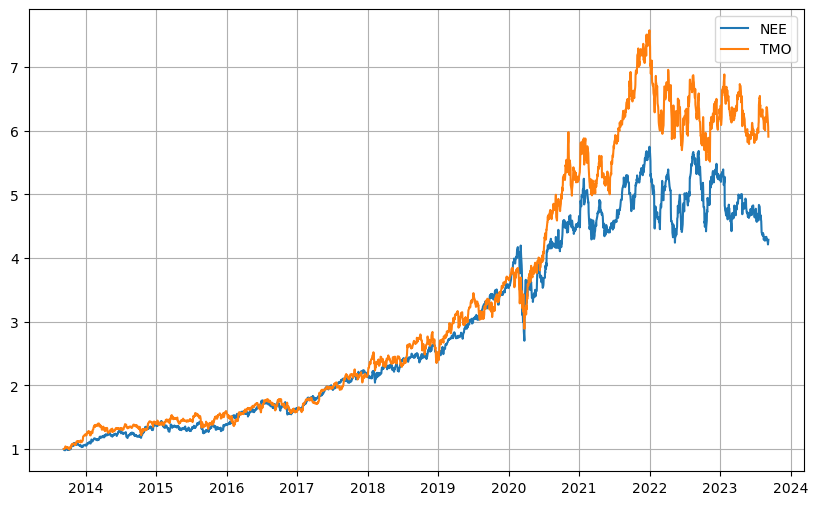

In [20]:
# Two Series
plt.figure(figsize = (10,6))
plt.plot(data2[ticker21])
plt.plot(data2[ticker22])
plt.legend([ticker21,ticker22])
plt.grid()
plt.show()

In [ ]:
Z=1.

data2["Hedge"] = 0.
data2["Spread"] = 0.
data2["Upper"] = 0.
data2["Lower"] = 0.
data2["Mean"] = 0.
data2["Signals"] = 0.

#calculate ourt hedge ratio
model=sm.regression.linear_model.OLS(data2[ticker21], data2[ticker22])
model = model.fit()
hedge = model.params[0]
data2["Hedge"] = hedge

data2["Spread"] = data2[ticker21] - (data2[ticker22] * hedge)

data2["Mean"] = (data2["Spread"]).rolling(400).mean()
data2["SD"] = (data2["Spread"]).rolling(400).std()

data2["Upper"] = data2["Mean"] + (Z * data2["SD"])
data2["Lower"] = data2["Mean"] - (Z * data2["SD"])

In [ ]:
data2 = strategy_signals_2(data2)
data2 = data2.ffill().dropna()

In [23]:
# Get Strategy Profits
data2["asset1"] = data2[ticker21].pct_change()
data2["asset2"] = data2[ticker22].pct_change()

data2["Return"] = (data2["asset1"] - (data2["Hedge"] * data2["asset2"])) * data2["Signals"].shift(1)
data2["cumulReturn"] = np.cumprod((data2["Return"]).fillna(0)+1)

In [24]:
longs = data2["Spread"][data2["Signals"] == 1.]
shorts = data2["Spread"][data2["Signals"] == -1.]

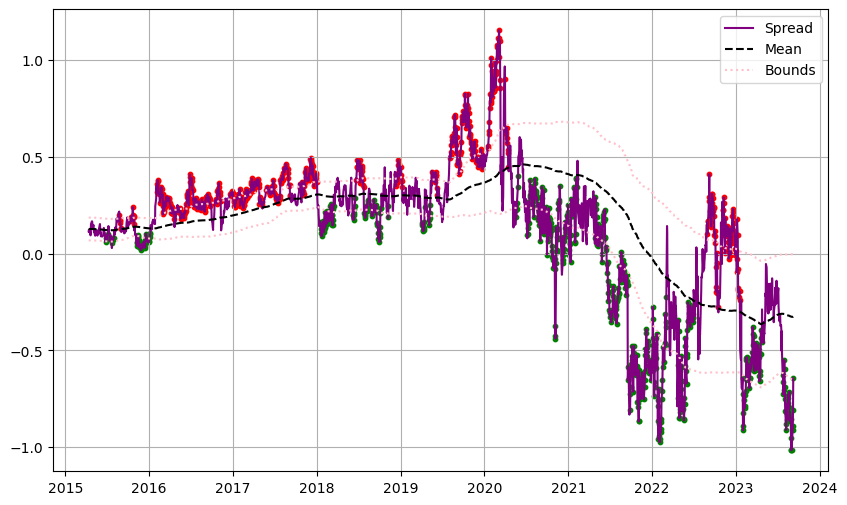

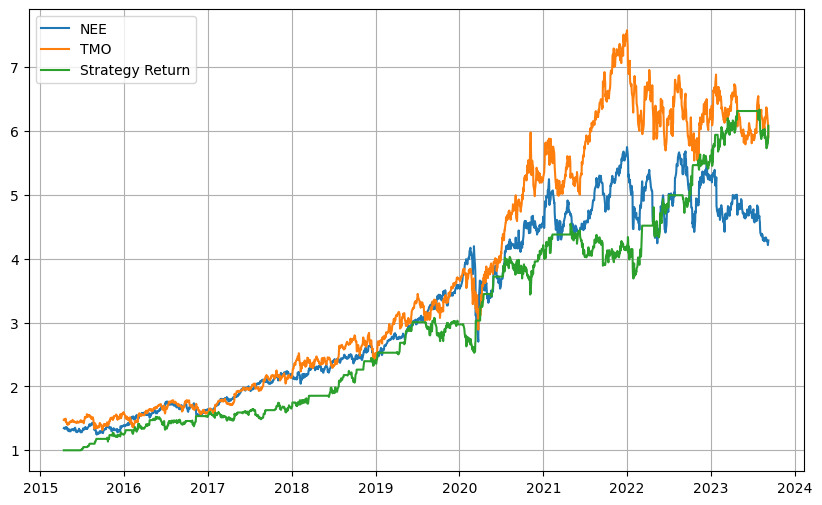

In [25]:
# Spread
pair1=data2["cumulReturn"]

plt.figure(figsize = (10,6))
plt.plot(data2["Spread"], c = "purple")
plt.plot(data2["Mean"], linestyle = "dashed", c = "black")
plt.plot(data2["Upper"], linestyle = "dotted", c = "pink")
plt.plot(data2["Lower"], linestyle = "dotted", c = "pink")

plt.scatter(longs.index, longs, c = "green" , s = 10 )
plt.scatter(shorts.index, shorts, c = "red" , s = 10 )

plt.legend(["Spread", "Mean", "Bounds"])
plt.grid()
plt.show()

# Plot the profits
plt.figure(figsize = (10,6))
plt.plot(data2[ticker21])
plt.plot(data2[ticker22])
plt.plot(data2["cumulReturn"])
plt.legend([ticker21,ticker22, "Strategy Return"])
plt.grid()
plt.show()

In [26]:
tsf2=data2["cumulReturn"]["2018-09-10":]/data2["cumulReturn"]["2018-09-10"]

## Sharpe

In [27]:
import numpy as np

returns_asset1 = [9.346719637, -17.20220668, 15.3221216, 51.2499407, 31.1601745]
returns_asset2 = [36.24535772, 27.81886287, 9.619120062, 14.36629014, 26.09691062]

risk_free_rate = 4.26

allocation_weights = np.arange(0, 1.1, 0.01)  

max_sharpe_ratio = 0
optimal_allocation = None


In [28]:
fs=0
fw1=0
fw2=0
fret=0
fvol=0
for weight_asset1 in allocation_weights:
    weight_asset2 = 1 - weight_asset1  
    
    portfolio_return = (weight_asset1 * 15.67 + 
                        weight_asset2 * 22.42)
    portfolio_std_dev = np.sqrt((weight_asset1**2 * np.var(returns_asset1) +
                                weight_asset2**2 * np.var(returns_asset2) +
                                2 * weight_asset1 * weight_asset2 * np.cov(returns_asset1, returns_asset2)[0][1]))

    sharpe_ratio = (portfolio_return - risk_free_rate) / portfolio_std_dev
    if fs<sharpe_ratio:
        fs=sharpe_ratio
        fw1=weight_asset1
        fw2=weight_asset2
        fret=portfolio_return
        fvol=portfolio_std_dev

In [29]:
fstrategy= fw1*tsf1 + fw2 *tsf2

In [30]:
sp = yf.download("^GSPC", start = "2018-09-10", end = "2023-09-10")

[*********************100%%**********************]  1 of 1 completed


In [31]:
sp = sp["Adj Close"]
sp = sp / sp.iloc[0]

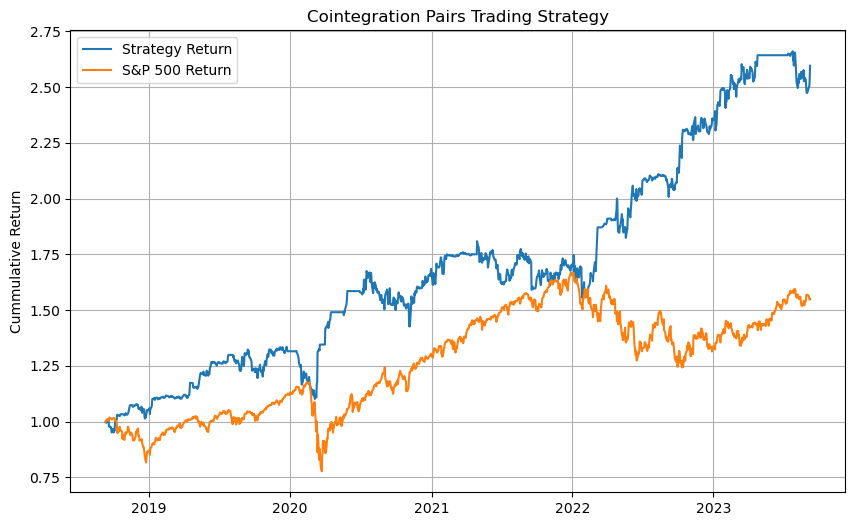

In [32]:
plt.figure(figsize = (10,6))
plt.plot(fstrategy)
plt.plot(sp)
plt.title("Cointegration Pairs Trading Strategy")
plt.ylabel("Cummulative Return")
plt.legend(["Strategy Return", "S&P 500 Return"])
plt.grid()
plt.show()